In [1]:
import pandas as pd
import numpy as np
import os
import sys
import shutil
import math

import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection, multipletests
from itertools import combinations

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
import seaborn as sns
import colorcet as cc
from random import sample, seed

from sklearn.model_selection import train_test_split

### ProCan train, BC test

In [2]:
x_input = 'data/ProCan-DepMapSanger_protein_matrix_6692_averaged.xlsx'
x = pd.read_excel(x_input, engine='openpyxl').drop(columns=['Project_Identifier'])
x.columns = x.columns.str.replace(';', '.')

In [5]:
x = x.set_index('Cell_Line')

In [8]:
x.index.str.lower().str.replace('-', '')

Index(['k052', 'te12', 'tmk1', 'sts0421', 'pl4', 'pci4b', 'pci30', 'hsc39',
       'h3255', 'emcbac2',
       ...
       '451lu', 'mmacsf', 'be13', 'mcixc', 'ramos2g64c10', 'cgthw1', 'h9',
       'grst', 'ymb1e', 'mm1s'],
      dtype='object', name='Cell_Line', length=949)

In [2]:
file_bc = 'data/breast_cancer.xlsx'
bc = pd.read_excel(file_bc, sheet_name=['B_protein_matrix','G_DrugResponse'])
bc_drug = bc['G_DrugResponse']
bc_protein = bc['B_protein_matrix']

In [4]:
file_proCan = 'data/pc_drug_response.csv' # calling the table that I created in this notebook
proCan = pd.read_csv(file_proCan, usecols=['drug_id','CHEMBL', 'cell_line_name', 'tissue', 'ln_IC50', 'drug_name', 'max_screening_conc', 'drug_owner', 'dataset','putative_target', 'putative_gene_target', 'target_pathway'])


In [4]:
file_chembl = 'data/drug_chembl.txt'
chembl = pd.read_csv(file_chembl, header=0, names=['Drug', 'CHEMBL'])
chembl

,Drug,CHEMBL
0,17-AAG,CHEMBL109480
1,5-FU,CHEMBL185
2,5-FdUR,CHEMBL917
3,AG1478,CHEMBL7917
4,Triciribine,CHEMBL331237
...,...,...
68,VX-680,CHEMBL572878
69,Valproic acid,CHEMBL109
70,Velcade,CHEMBL325041
71,Vinorelbine,CHEMBL553025


In [8]:
proCan.tissue.value_counts().shape

(27,)

#### missing values

In [14]:
csiro_palette = ['#00A9CE', '#007377', '#1E22AA', '#00B0F0', '#6D2077']

sns.set_palette(palette=csiro_palette)

<Axes: >

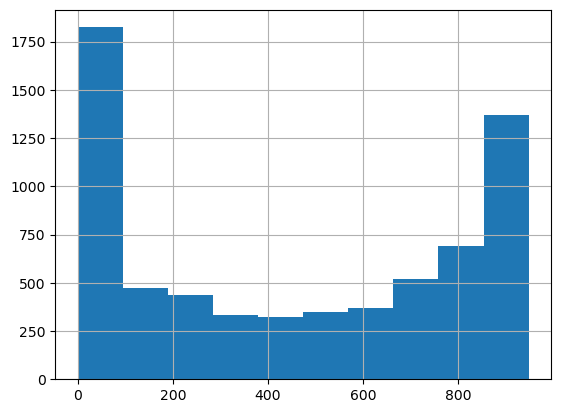

In [13]:
x.isna().sum(axis=0).hist()

In [47]:
sum(x.isna().sum(axis=0) > 800)

1784

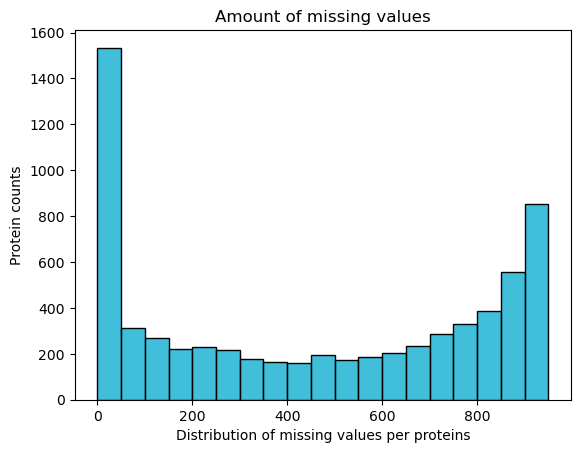

In [46]:
hist = sns.histplot(x.isna().sum(axis=0), bins=np.linspace(0,950,20))
hist.set(xlabel="Distribution of missing values per proteins", ylabel="Protein counts", title="Amount of missing values")
plt.savefig('analysis/img/missing.png', bbox_inches='tight')
plt.show()

#### creating drug response files

In [13]:
proCan.CHEMBL.unique()

array(['CHEMBL92', 'CHEMBL34259', 'CHEMBL939', 'CHEMBL98',
       'CHEMBL1201182', 'CHEMBL288441', 'CHEMBL603469', 'CHEMBL109480',
       'CHEMBL1173655', 'CHEMBL191334', 'CHEMBL202721', 'CHEMBL1879463',
       'CHEMBL1614701', 'CHEMBL185', 'CHEMBL1351', 'CHEMBL428647',
       'CHEMBL601719', 'CHEMBL413', 'CHEMBL1336', 'CHEMBL414804',
       'CHEMBL553', 'CHEMBL888', 'CHEMBL325041', 'CHEMBL83',
       'CHEMBL2103875', 'CHEMBL417', 'CHEMBL1231160', 'CHEMBL3137336',
       'CHEMBL554', 'CHEMBL64925', 'CHEMBL553025'], dtype=object)

In [5]:
bc_drug = bc['G_DrugResponse']
bc_drug = bc_drug.merge(chembl, on='Drug' )
bc_drug = bc_drug.set_index(['Drug', 'CHEMBL'])
bc_drug = bc_drug.stack(dropna=True)

In [6]:
df = bc_drug.index.to_frame( index=False)
df['IC50'] = bc_drug.to_numpy()

In [7]:
bc_drug = df

In [8]:
bc_drug

,Drug,CHEMBL,2,IC50
0,17-AAG,CHEMBL109480,184a1,7.93
1,17-AAG,CHEMBL109480,184b5,7.56
2,17-AAG,CHEMBL109480,600mpe,6.65
3,17-AAG,CHEMBL109480,au565,7.24
4,17-AAG,CHEMBL109480,bt474,5.84
...,...,...,...,...
3310,ZM447439,CHEMBL202721,sum225,4.98
3311,ZM447439,CHEMBL202721,sum229,5.93
3312,ZM447439,CHEMBL202721,sum52,5.46
3313,ZM447439,CHEMBL202721,t47d,4.94


In [9]:
bc_drug.columns = ['Drug', 'CHEMBL', 'cell_line_name', 'IC50']
bc_drug['ln_IC50'] = bc_drug.IC50.apply(np.log)
bc_drug

,Drug,CHEMBL,cell_line_name,IC50,ln_IC50
0,17-AAG,CHEMBL109480,184a1,7.93,2.070653
1,17-AAG,CHEMBL109480,184b5,7.56,2.022871
2,17-AAG,CHEMBL109480,600mpe,6.65,1.894617
3,17-AAG,CHEMBL109480,au565,7.24,1.979621
4,17-AAG,CHEMBL109480,bt474,5.84,1.764731
...,...,...,...,...,...
3310,ZM447439,CHEMBL202721,sum225,4.98,1.605430
3311,ZM447439,CHEMBL202721,sum229,5.93,1.780024
3312,ZM447439,CHEMBL202721,sum52,5.46,1.697449
3313,ZM447439,CHEMBL202721,t47d,4.94,1.597365


In [11]:
bc_drug.CHEMBL.value_counts()

CHEMBL325041     92
CHEMBL319467     87
CHEMBL1234354    49
CHEMBL3545078    49
CHEMBL1770916    49
                 ..
CHEMBL558642     42
CHEMBL3137336    42
CHEMBL1201182    40
CHEMBL1173655    39
CHEMBL1908360    39
Name: CHEMBL, Length: 71, dtype: int64

In [14]:
bc_drug[bc_drug.CHEMBL== 'CHEMBL325041'].cell_line_name.value_counts().shape

(47,)

In [19]:
bc_drug.to_csv('data/bc_drug_response.csv', index=False)

##### IC 50 distributions

<Axes: >

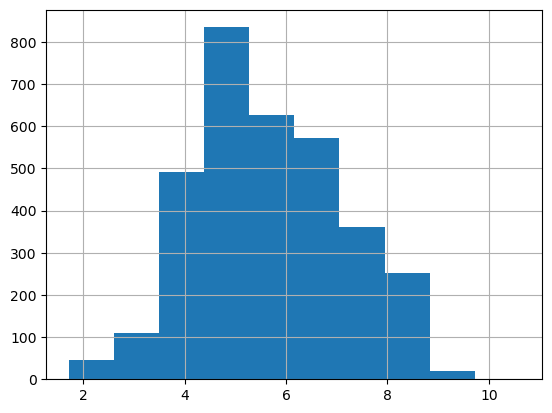

In [61]:
bc_drug.IC50.hist()

<Axes: >

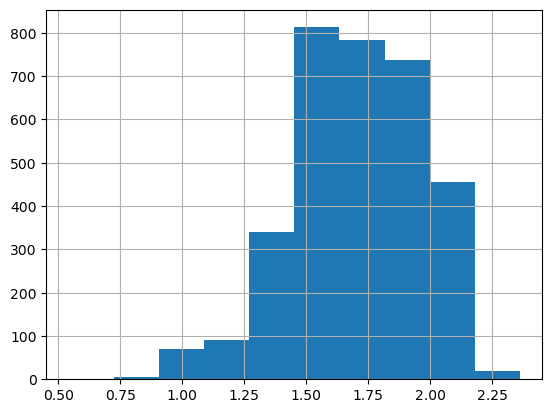

In [68]:
bc_drug.ln_IC50.hist()

<Axes: >

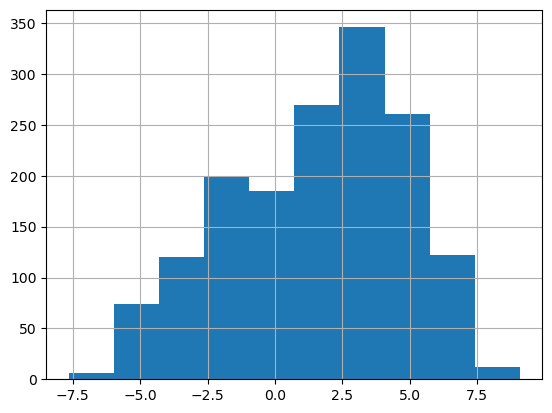

In [69]:
proCan[proCan.tissue=='Breast'].ln_IC50.hist()

#### creating protein matrices

In [38]:
bc_protein = bc_protein.drop(['GeneName'], axis=1).set_index('UniprotID').transpose()
bc_protein.index = bc_protein.index.str[:-2]
bc_protein = bc_protein.groupby(level=0).mean(numeric_only=True)

In [39]:
bc_protein['Cell_Line'] = bc_protein.index

In [42]:
bc_protein

UniprotID,A0AV96,A0AVT1,A0FGR8,A0MZ66,A0PJW6,A1L0T0,A1L390,A1X283,A2RRP1,A3KMH1,...,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8,Cell_Line
184a1,NaN,15.873348,53.942375,9.008490,NaN,12.938957,16.196413,NaN,32.003300,46.202575,...,NaN,19.500440,NaN,3.010523,NaN,9.476490,6.364410,3.48803,11.961845,184a1
184b5,6.132990,17.295725,38.246475,3.170400,9.647190,10.812215,14.761645,NaN,15.858422,42.467675,...,NaN,30.668675,5.562890,7.743427,NaN,1.744210,6.268980,NaN,10.006103,184b5
600mpe,21.540850,39.562675,18.889233,22.820655,NaN,NaN,14.604500,5.979973,10.540900,63.283830,...,6.983600,38.104475,NaN,23.952300,20.207010,7.493905,7.521927,6.17938,29.347525,600mpe
au565,25.840200,24.883325,24.677250,37.584450,8.722810,10.146805,10.408070,3.107980,29.393800,35.259850,...,7.566770,27.403000,11.371800,18.203263,NaN,20.944700,8.001240,NaN,17.259375,au565
bt20,30.347400,46.411275,29.007350,20.372200,NaN,NaN,3.891560,NaN,11.868887,8.002970,...,9.582587,54.408425,17.753300,NaN,NaN,10.936840,NaN,NaN,11.676312,bt20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uacc3199,NaN,33.916725,47.276575,17.956035,11.624690,16.683645,26.582053,22.080820,18.114023,83.531675,...,NaN,15.149943,7.782615,32.490792,34.174840,12.368945,20.293450,NaN,5.909140,uacc3199
uacc893,27.505100,18.454075,70.665800,78.800450,15.879140,3.703130,NaN,14.089728,20.346490,20.287825,...,7.311245,63.363925,NaN,1.941680,NaN,NaN,6.929695,NaN,34.871475,uacc893
zr751,31.407625,56.773125,37.163950,122.728800,6.553900,71.633250,16.750900,10.746910,17.828167,29.941975,...,9.161843,33.700650,5.700220,NaN,1.776340,6.130000,10.614895,5.94097,38.788375,zr751
zr7530,28.234625,45.110950,58.573925,66.592925,15.371625,17.723842,8.293000,NaN,32.741450,41.879175,...,7.701603,38.018300,NaN,21.439205,23.525867,8.204730,6.407430,4.13274,69.949175,zr7530


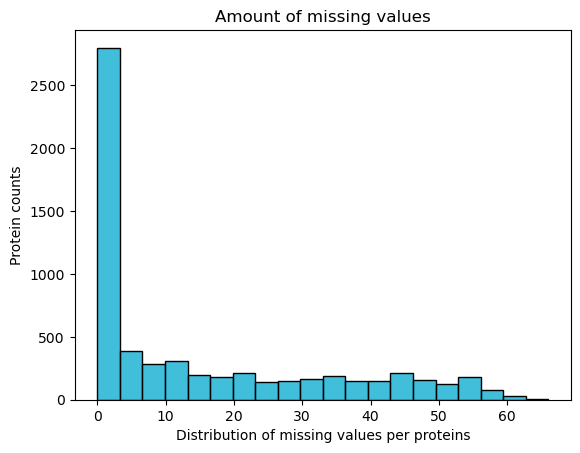

In [45]:
hist = sns.histplot(bc_protein.isna().sum(axis=0), bins=20)
hist.set(xlabel="Distribution of missing values per proteins", ylabel="Protein counts", title="Amount of missing values")
plt.savefig('analysis/img/bc_missing.png', bbox_inches='tight')
plt.show()

In [51]:
bc_protein = bc_protein.set_index('Cell_Line')
#x = x.set_index('Cell_Line')

In [52]:
bc_protein.iloc[:,:] = np.log2(bc_protein.to_numpy())

In [ ]:
x.columns = [p.split('.')[0] for p in x.columns.to_list()]

In [18]:
pc_mask = [p in bc_protein.columns.to_list() for p in x.columns.to_list()]
bc_mask = [p in x.columns.to_list() for p in bc_protein.columns.to_list()]
sum(pc_mask), sum(bc_mask)

(5331, 5331)

In [24]:
pc_cell_line = proCan.cell_line_name.unique() # this does not need to be done, as the inner merging in create data will make sure we have the correct celll lines downstream

In [26]:
x = x.loc[[c in pc_cell_line for c in x.index.to_list()]]

In [27]:
x[x.columns[pc_mask]].to_csv('data/pc_protein.csv')

In [22]:
bc_protein[bc_protein.columns[bc_mask]].to_csv('data/bc_protein.csv')

#### Uniprot to prot name file

In [5]:
prots = x.columns[1:].to_frame()

In [12]:
prots['UniProt'] = prots[0].str.split('.', expand=True)

In [13]:
prots['Protein'] = prots[1].str.split('_', expand=True)[0]

In [16]:
prots.drop(columns=[0,1]).to_csv('snakemake/data/uniprot_protein.csv', index=False)

### drug and tissue filtering

In [12]:
file_proCan = 'data/subset_drug_response.csv' # calling the table that I created in this notebook
proCan = pd.read_csv(file_proCan, usecols=['drug_id','CHEMBL', 'cell_line_name', 'tissue', 'ln_IC50', 'drug_name', 'max_screening_conc', 'drug_owner', 'dataset','putative_target', 'putative_gene_target', 'target_pathway'])
proCan

,drug_id,putative_target,CHEMBL,cell_line_name,drug_name,putative_gene_target,dataset,ln_IC50,drug_owner,max_screening_conc,target_pathway,tissue
0,1007,Microtubule stabiliser,CHEMBL92,5637,Docetaxel,NaN,GDSC2,-6.011902,GDSC,0.0125,Mitosis,Bladder
1,1007,Microtubule stabiliser,CHEMBL92,201T,Docetaxel,NaN,GDSC2,-5.263725,GDSC,0.0125,Mitosis,Lung
2,1007,Microtubule stabiliser,CHEMBL92,22RV1,Docetaxel,NaN,GDSC2,-3.534340,GDSC,0.0125,Mitosis,Prostate
3,1007,Microtubule stabiliser,CHEMBL92,23132-87,Docetaxel,NaN,GDSC2,-4.802981,GDSC,0.0125,Mitosis,Stomach
4,1007,Microtubule stabiliser,CHEMBL92,42-MG-BA,Docetaxel,NaN,GDSC2,-4.954833,GDSC,0.0125,Mitosis,Central Nervous System
...,...,...,...,...,...,...,...,...,...,...,...,...
25187,2106,"AKT1, AKT2, AKT3",CHEMBL3137336,WM278,Uprosertib,AKT1;AKT2;AKT3,GDSC2,2.215269,GDSC,10.0000,PI3K/MTOR signaling,Skin
25188,2106,"AKT1, AKT2, AKT3",CHEMBL3137336,WM35,Uprosertib,AKT1;AKT2;AKT3,GDSC2,2.572707,GDSC,10.0000,PI3K/MTOR signaling,Skin
25189,2106,"AKT1, AKT2, AKT3",CHEMBL3137336,WM793B,Uprosertib,AKT1;AKT2;AKT3,GDSC2,1.661006,GDSC,10.0000,PI3K/MTOR signaling,Skin
25190,2106,"AKT1, AKT2, AKT3",CHEMBL3137336,YAPC,Uprosertib,AKT1;AKT2;AKT3,GDSC2,6.535078,GDSC,10.0000,PI3K/MTOR signaling,Pancreas


In [16]:
proCan = proCan[~proCan.drug_name.str.contains('Cyclophosphamide')]
proCan = proCan[~proCan.drug_name.str.contains('(0.001)')]

C:\Users\wen068\AppData\Local\Temp\ipykernel_16708\3752269035.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  proCan = proCan[~proCan.drug_name.str.contains('(0.001)')]


In [10]:
proCan.drug_name.value_counts()

ZM447439          819
Afatinib          818
Pevonedistat      818
Dactolisib        818
Tamoxifen         818
Nutlin-3a (-)     818
Docetaxel         818
Vorinostat        818
Gefitinib         818
Trametinib        818
MG-132            817
Methotrexate      815
Lestaurtinib      814
Oxaliplatin       814
Tanespimycin      813
Bosutinib         813
Selumetinib       813
5-Fluorouracil    813
Lapatinib         813
Crizotinib        813
Epirubicin        808
Paclitaxel        808
Erlotinib         808
Sorafenib         808
Bortezomib        807
Gemcitabine       807
Temsirolimus      806
Vinorelbine       805
Rapamycin         803
Uprosertib        802
Carboplatin       795
Name: drug_name, dtype: int64

In [49]:
proCan[['CHEMBL','putative_target', 'putative_gene_target', 'target_pathway', 'drug_name']].drop_duplicates().sort_values('CHEMBL')

,CHEMBL,putative_target,putative_gene_target,target_pathway,drug_name
5702,CHEMBL109480,HSP90,HSP90AA1;HSP90AB1,Protein stability and degradation,Tanespimycin
6515,CHEMBL1173655,"EGFR, ERBB2",EGFR;ERBB2,EGFR signaling,Afatinib
3269,CHEMBL1201182,MTOR,MTOR,PI3K/MTOR signaling,Temsirolimus
21121,CHEMBL1231160,NAE,NAE1,Other,Pevonedistat
14617,CHEMBL1336,"PDGFR, KIT, VEGFR, RAF",FLT1;KIT;PDGFRA;PDGFRB;RAF1,"Other, kinases",Sorafenib
11398,CHEMBL1351,DNA akylating agent,NaN,DNA replication,Carboplatin
9788,CHEMBL1614701,"MEK1, MEK2",MAP2K1;MAP2K2,ERK MAPK signaling,Selumetinib
10585,CHEMBL185,Antimetabolite (DNA & RNA),NaN,Other,5-Fluorouracil
8970,CHEMBL1879463,"PI3K (class 1), MTORC1, MTORC2",PIK3CA;PIK3CB;PIK3CD;PIK3CG;MTOR,PI3K/MTOR signaling,Dactolisib
7333,CHEMBL191334,MDM2,MDM2,p53 pathway,Nutlin-3a (-)


In [19]:
file_chembl = 'data/drug_chembl.txt'
chembl = pd.read_csv(file_chembl)
chembl

,Drug,chEMBL
0,17-AAG,CHEMBL109480
1,5-FU,CHEMBL185
2,5-FdUR,CHEMBL917
3,AG1478,CHEMBL7917
4,Triciribine,CHEMBL331237
...,...,...
68,VX-680,CHEMBL572878
69,Valproic acid,CHEMBL109
70,Velcade,CHEMBL325041
71,Vinorelbine,CHEMBL553025


In [20]:
mask = [d in chembl.chEMBL.to_list() for d in proCan.CHEMBL]
drug_merge = proCan[mask].copy()

In [21]:
drug_merge[['drug_name', 'drug_id', 'max_screening_conc','dataset', 'drug_owner']][drug_merge.tissue == 'Breast'].value_counts().head(10)

drug_name       drug_id  max_screening_conc  dataset  drug_owner
5-Fluorouracil  1073     32.0000             GDSC2    GDSC          52
Vorinostat      1012     10.0000             GDSC2    GDSC          52
Docetaxel       1007     0.0125              GDSC2    GDSC          52
Nutlin-3a (-)   1047     10.0000             GDSC2    GDSC          52
MG-132          1862     4.0000              GDSC2    GDSC          52
Gemcitabine     1190     10.0000             GDSC2    GDSC          51
Vinorelbine     2048     0.1000              GDSC2    GDSC          51
Trametinib      1372     1.0000              GDSC2    GDSC          51
Tamoxifen       1199     10.0000             GDSC2    GDSC          51
Sorafenib       1085     10.0000             GDSC2    GDSC          51
dtype: int64

#### all cell lines but "Haematopoietic and Lymphoid"

In [8]:
drug_merge[['drug_name', 'drug_id', 'max_screening_conc','dataset', 'drug_owner']][drug_merge.tissue != "Haematopoietic and Lymphoid"].value_counts().head(10)

drug_name       drug_id  max_screening_conc  dataset  drug_owner
MG-132          1862     4.0000              GDSC2    GDSC          817
Nutlin-3a (-)   1047     10.0000             GDSC2    GDSC          815
Docetaxel       1007     0.0125              GDSC2    GDSC          814
Trametinib      1372     1.0000              GDSC2    GDSC          814
Oxaliplatin     1089     10.0000             GDSC2    GDSC          814
Afatinib        1032     10.0000             GDSC2    GDSC          814
Crizotinib      1083     10.0000             GDSC2    GDSC          813
5-Fluorouracil  1073     32.0000             GDSC2    GDSC          813
Lapatinib       1558     10.0000             GDSC2    GDSC          813
Vorinostat      1012     10.0000             GDSC2    GDSC          809
dtype: int64

In [22]:
subset = drug_merge[(drug_merge.tissue != "Haematopoietic and Lymphoid") & (drug_merge.drug_owner == 'GDSC')].copy()
subset = subset.sort_values(['drug_id', 'max_screening_conc', 'dataset'], ascending=[True, False, False]).drop_duplicates(subset=['CHEMBL', 'cell_line_name'])
subset

,drug_id,putative_target,CHEMBL,cell_line_name,drug_name,putative_gene_target,dataset,ln_IC50,drug_owner,max_screening_conc,target_pathway,tissue
0,1007,Microtubule stabiliser,CHEMBL92,5637,Docetaxel,NaN,GDSC2,-6.011902,GDSC,0.0125,Mitosis,Bladder
1,1007,Microtubule stabiliser,CHEMBL92,201T,Docetaxel,NaN,GDSC2,-5.263725,GDSC,0.0125,Mitosis,Lung
2,1007,Microtubule stabiliser,CHEMBL92,22RV1,Docetaxel,NaN,GDSC2,-3.534340,GDSC,0.0125,Mitosis,Prostate
3,1007,Microtubule stabiliser,CHEMBL92,23132-87,Docetaxel,NaN,GDSC2,-4.802981,GDSC,0.0125,Mitosis,Stomach
4,1007,Microtubule stabiliser,CHEMBL92,42-MG-BA,Docetaxel,NaN,GDSC2,-4.954833,GDSC,0.0125,Mitosis,Central Nervous System
...,...,...,...,...,...,...,...,...,...,...,...,...
25187,2106,"AKT1, AKT2, AKT3",CHEMBL3137336,WM278,Uprosertib,AKT1;AKT2;AKT3,GDSC2,2.215269,GDSC,10.0000,PI3K/MTOR signaling,Skin
25188,2106,"AKT1, AKT2, AKT3",CHEMBL3137336,WM35,Uprosertib,AKT1;AKT2;AKT3,GDSC2,2.572707,GDSC,10.0000,PI3K/MTOR signaling,Skin
25189,2106,"AKT1, AKT2, AKT3",CHEMBL3137336,WM793B,Uprosertib,AKT1;AKT2;AKT3,GDSC2,1.661006,GDSC,10.0000,PI3K/MTOR signaling,Skin
25190,2106,"AKT1, AKT2, AKT3",CHEMBL3137336,YAPC,Uprosertib,AKT1;AKT2;AKT3,GDSC2,6.535078,GDSC,10.0000,PI3K/MTOR signaling,Pancreas


In [24]:
drug_list = subset.CHEMBL.value_counts()[subset.CHEMBL.value_counts() >= 600].index.to_list()
drug_mask = [d in drug_list for d in subset.CHEMBL]
subset[drug_mask].to_csv('data/subset_drug_response.csv', index=False)

In [ ]:
subset[drug_mask].to_csv('data/subset_drug_response.csv', index=False)

### Cell Lines Filtering and Overlap

In [3]:
x_input = 'data/ProCan-DepMapSanger_protein_matrix_6692_averaged.xlsx'
x = pd.read_excel(x_input, engine='openpyxl').drop(columns=['Project_Identifier'])
x.columns = x.columns.str.replace(';', '.')

In [23]:
abundance = x.set_index('Cell_Line').to_numpy().reshape([1,-1])
abundance = abundance[~np.isnan(abundance)]

In [24]:
abundance.shape

(3307910,)

In [28]:
abundance = abundance[abundance != abundance.max()] #the max value is an extreme outlier of ~39000

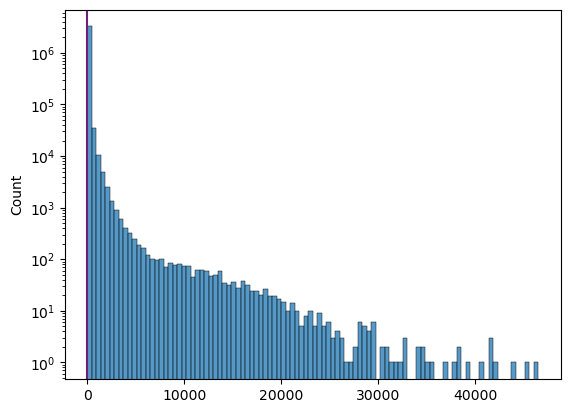

In [36]:
sns.histplot(np.power(2,abundance), bins=100, log=True)
plt.axvline(2, 0, c="#6D2077")
plt.show()

In [ ]:
cell_lines = breast.cell_line_name.unique()
cl_train, cl_test = train_test_split(cell_lines, test_size=0.2, train_size=0.8, random_state=42)
len(cl_train), len(cl_test)

(41, 11)

In [ ]:
train_mask = [c in cl_train for c in x.Cell_Line]
test_mask = [c in cl_test for c in x.Cell_Line]
sum(train_mask), sum(test_mask)

(39, 11)

In [2]:
file_bc = 'data/breast_cancer.xlsx'
bc = pd.read_excel(file_bc, sheet_name=['B_protein_matrix','G_DrugResponse'])
bc_drug = bc['G_DrugResponse']
bc_protein = bc['B_protein_matrix']

In [16]:
np.log(bc_drug.set_index('Drug').to_numpy())

array([[2.07065304, 2.02287119, 1.89461685, ..., 1.92132467,        nan,
        1.98375629],
       [1.35583515, 0.54232429, 1.41342303, ..., 1.50851199,        nan,
        1.59938758],
       [1.30019166, 1.29472717, 1.75958057, ..., 1.71379793,        nan,
        1.64093658],
       ...,
       [       nan,        nan, 1.78674693, ..., 1.99741771,        nan,
        2.08567209],
       [1.87180218, 1.87946505, 1.35583515, ..., 1.77664583,        nan,
        1.77495235],
       [1.45861502, 1.45861502, 1.38629436, ..., 1.69927862,        nan,
               nan]])

In [17]:
# BC dataset cell lines
len(bc_drug.columns.to_list())

66

In [18]:
# Overlap
sum([c.upper() in drug_merge[drug_merge.tissue == 'Breast'].cell_line_name.str.replace('-', '').unique() for c in bc_drug.columns.to_list()])

41

In [19]:
# drug response cell lines
len(drug_merge[drug_merge.tissue == 'Breast'].cell_line_name.unique())

52

In [20]:
# protein matrix cell lines
sum([c in cell_lines for c in x.Cell_Line])

50

In [21]:
# protein matrix to breast
sum([c.upper() in x.Cell_Line.str.replace('-', '').unique() for c in bc_drug.columns.to_list()])

40

In [3]:
bc_protein = bc_protein.drop(['GeneName'], axis=1).set_index('UniprotID').transpose()

In [4]:
bc_protein.index = bc_protein.index.str[:-2]
bc_protein

UniprotID,A0AV96,A0AVT1,A0FGR8,A0MZ66,A0PJW6,A1L0T0,A1L390,A1X283,A2RRP1,A3KMH1,...,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
184a1,NaN,13.7158,38.31570,NaN,NaN,NaN,12.02410,NaN,12.01090,30.75640,...,5.62445,NaN,10.5656,NaN,2.52737,NaN,NaN,NaN,NaN,8.27729
cal148,11.39620,62.2443,7.54967,31.83140,NaN,4.34349,NaN,5.31872,6.89759,1.61165,...,NaN,NaN,15.6373,NaN,NaN,3.07059,NaN,NaN,NaN,23.04620
hcc1599,14.86650,74.9893,30.95200,35.22680,NaN,10.79930,7.69869,77.24460,9.43528,19.44780,...,5.76010,5.87079,61.0741,NaN,NaN,NaN,6.60313,15.40790,3.4497,12.19540
hcc1806,NaN,24.3564,43.64930,13.71210,NaN,23.36850,18.10510,17.91770,7.32378,32.65990,...,4.73728,NaN,48.5096,NaN,5.19427,NaN,NaN,8.98626,NaN,13.64630
hcc1937,23.13140,23.8761,32.98270,4.58101,NaN,20.03130,16.81150,4.45660,9.94062,21.22400,...,NaN,NaN,31.8257,9.43315,NaN,20.70120,9.46561,NaN,NaN,8.67879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hcc1187,NaN,47.5081,3.56366,14.95320,NaN,1.16499,NaN,24.22160,7.55196,16.56110,...,2.77604,NaN,11.0935,NaN,NaN,NaN,NaN,2.82842,11.4304,14.08190
hcc1395,NaN,43.9696,16.58260,4.85285,NaN,6.83762,NaN,22.84010,1.07305,8.20341,...,2.68106,NaN,28.4184,NaN,NaN,NaN,NaN,NaN,NaN,25.93250
hcc1419,22.15880,60.1592,9.17667,30.24370,NaN,45.63430,NaN,NaN,25.37850,7.86560,...,NaN,14.66430,33.2965,NaN,NaN,NaN,10.02580,NaN,NaN,19.77580
hcc1428,NaN,16.2026,37.89820,34.44580,NaN,32.10960,NaN,5.66725,15.70810,2.13953,...,NaN,NaN,72.3176,NaN,NaN,NaN,NaN,7.99899,NaN,36.10790


In [5]:
# maybe take average per cell line?
bc_protein.index.value_counts()

184a1       4
efm192a     4
uacc3199    4
t47d        4
sw527       4
           ..
mcf12a      4
cal120      3
hcc70       3
sum44       3
hcc2688     3
Length: 76, dtype: int64

<Axes: >

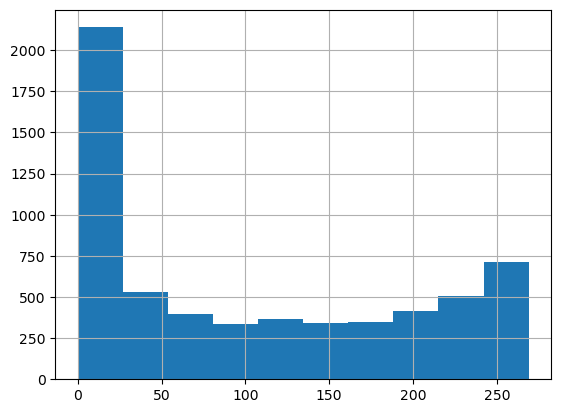

In [6]:
bc_protein.isna().sum().hist()

In [44]:
bc_abundance = bc_protein.to_numpy().reshape([1,-1])
bc_abundance = bc_abundance[~np.isnan(bc_abundance)]

In [45]:
bc_abundance.shape

(1198080,)

In [28]:
bc_abundance = abundance[abundance != abundance.max()] #the max value is an extreme outlier of ~39000

In [49]:
bc_abundance.min()

0.0285404

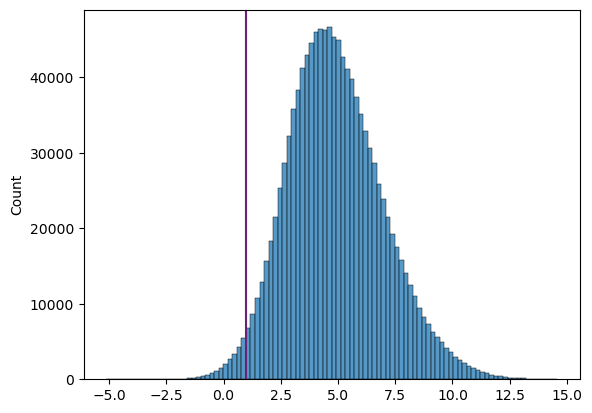

In [48]:
sns.histplot(np.log2(bc_abundance), bins=100)
plt.axvline(1, 0, c="#6D2077")
plt.show()

In [55]:
bc_protein.shape

(300, 6091)

In [17]:
# overlap proteins
sum([p in x.columns.str[:6].to_list() for p in bc_protein.columns])

5331

In [24]:
x = x.set_index('Cell_Line')

In [25]:
protein_mask = [p in bc_protein for p in x.columns.str[:6]]
sum(protein_mask)

5331

Take only overlap proteins, but all breast cancer cell lines

In [26]:
x = x[x.columns[protein_mask]]
x.shape

(949, 5331)

In [87]:
x

,P37108.SRP14_HUMAN,Q96JP5.ZFP91_HUMAN,Q9Y4H2.IRS2_HUMAN,P36578.RL4_HUMAN,Q6SPF0.SAMD1_HUMAN,O76031.CLPX_HUMAN,Q8WUQ7.CATIN_HUMAN,A6NIH7.U119B_HUMAN,Q9BTD8.RBM42_HUMAN,Q9P258.RCC2_HUMAN,...,Q9NRY2.SOSSC_HUMAN,Q9UHN1.DPOG2_HUMAN,Q9GZQ3.COMD5_HUMAN,Q8IUR0.TPPC5_HUMAN,O15484.CAN5_HUMAN,Q9HBF4.ZFYV1_HUMAN,Q96RT7.GCP6_HUMAN,Q8IVH4.MMAA_HUMAN,Q86SZ2.TPC6B_HUMAN,Q5TA45.INT11_HUMAN
Cell_Line,,,,,,,,,,,,,,,,,,,,,
K052,7.109545,3.414941,NaN,7.866614,3.895467,4.196655,NaN,NaN,3.190877,7.358065,...,NaN,NaN,2.033698,3.311837,NaN,NaN,1.35322,NaN,NaN,2.639977
TE-12,6.828022,4.143455,2.237808,7.628785,3.198109,4.609018,NaN,2.47059,3.695348,5.707904,...,NaN,2.802152,NaN,2.328577,NaN,NaN,NaN,NaN,3.13888,3.196077
TMK-1,7.014256,4.199872,2.440552,8.124585,NaN,4.768811,NaN,NaN,NaN,5.522833,...,1.086323,NaN,NaN,3.337898,NaN,NaN,NaN,NaN,NaN,NaN
STS-0421,5.285911,3.357894,NaN,7.972680,NaN,4.520923,NaN,NaN,2.730884,4.294287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.790234
PL4,5.707857,NaN,NaN,6.225738,NaN,4.495795,NaN,NaN,2.879809,NaN,...,NaN,3.737752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGTH-W-1,6.316308,4.869332,NaN,7.624330,3.926891,4.472120,NaN,NaN,3.484641,5.439826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H9,6.230865,2.716858,NaN,7.235027,3.420646,4.717799,NaN,NaN,3.625137,6.155179,...,NaN,NaN,NaN,2.680997,NaN,NaN,NaN,NaN,NaN,NaN
GR-ST,7.004074,NaN,NaN,7.581500,NaN,4.590818,NaN,NaN,3.329604,6.430465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
x[train_mask].to_csv("data/train_breast_matrix.csv", index=True) 
x[test_mask].to_csv("data/test_breast_matrix.csv", index=True)

In [73]:
bc_protein.columns[[p not in x.columns.str[:6].to_list() for p in bc_protein.columns]]

Index(['A0PJW6', 'A4D1U4', 'A5A3E0', 'A5PLN9', 'A6ND36', 'A6NGQ2', 'A6NL28',
       'A7E2V4', 'A7KAX9', 'C9JI98',
       ...
       'Q9Y6A9', 'Q9Y6G3', 'Q9Y6G5', 'Q9Y6I4', 'Q9Y6I8', 'Q9Y6J9', 'Q9Y6K0',
       'Q9Y6R4', 'Q9Y6W3', 'Q9Y6X3'],
      dtype='object', name='UniprotID', length=760)

bc uses gene names and not protein names, use only uniport handle to compare

#### subset

In [27]:
cell_lines = subset.cell_line_name.unique()
cl_train, cl_test = train_test_split(cell_lines, test_size=0.2, train_size=0.8, random_state=42)
len(cl_train), len(cl_test)

(655, 164)

In [28]:
train_mask = [c in cl_train for c in x.index]
test_mask = [c in cl_test for c in x.index]
sum(train_mask), sum(test_mask)

(629, 155)

In [24]:
x[train_mask].to_csv("data/train_subset_matrix.csv", index=True) 
x[test_mask].to_csv("data/test_subset_matrix.csv", index=True)

In [34]:
x[np.add(train_mask, test_mask)].to_csv("data/subset_matrix.csv", index=True)

In [33]:
np.add(train_mask, test_mask).shape

(949,)

### PCA

In [2]:
from sklearn.decomposition import PCA

In [43]:
bc = pd.read_csv('data/bc_protein.csv').set_index('Cell_Line')  # updated to log2 values
pc = pd.read_csv('data/pc_protein.csv').set_index('Cell_Line')

In [44]:
bc.shape, pc.shape

((76, 5331), (784, 5331))

In [167]:
proteins = bc.columns.to_numpy()

In [123]:
def shift(x, oldLow=-5, oldHigh=16, newLow=0, newHigh=21):
    return ((x - oldLow) / (oldHigh - oldLow) * (newHigh - newLow) + newLow )

pc = pc.apply(shift, raw=True)
bc = bc.apply(shift, raw=True)

In [97]:
def remove_nan(x, test):
    t = 0.2
    n = x.shape[0]
    # count missing over full data set?
    na_count = x.isna().sum(axis=0)
    mask = na_count.iloc[:].apply(lambda x: x > t * n)  # ture for all proteins, that have more nan than the threshold t
    x = x.drop(columns=na_count.index[mask])
    test = test.drop(columns=na_count.index[mask])
    return x, test

In [98]:
pc, bc = remove_nan(pc, bc)
pc.shape

(784, 2335)

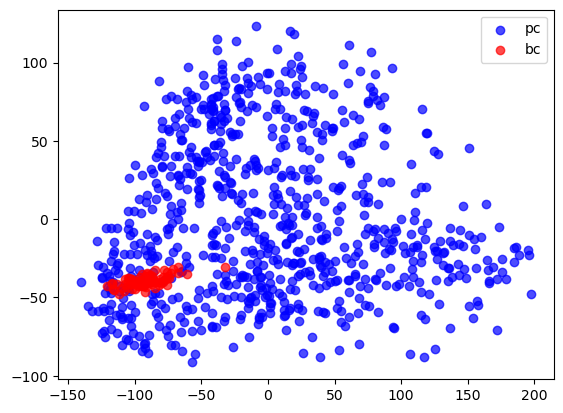

In [124]:
pca = PCA(n_components=2).fit(pc.fillna(0).values[:, :-1])
pc_trans = pca.transform(pc.fillna(0).values[:,:-1])

bc_trans = pca.transform(bc.fillna(0).values[:,:-1])

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x=pc_trans[:,0], y=pc_trans[:,1],c = 'b', label='pc', alpha=0.7)
ax1.scatter(x=bc_trans[:,0], y=bc_trans[:,1],c = 'r', label='bc', alpha=0.7)

plt.legend(loc='upper right')
plt.show()

In [125]:
bc['data'] = 'bc'
pc['data'] = 'pc'

data = pd.concat([bc, pc], join = 'inner').fillna(0)

In [126]:
pca = PCA(n_components=2).fit(data.values[:, :-1])
transformed = pca.transform(data.values[:,:-1])

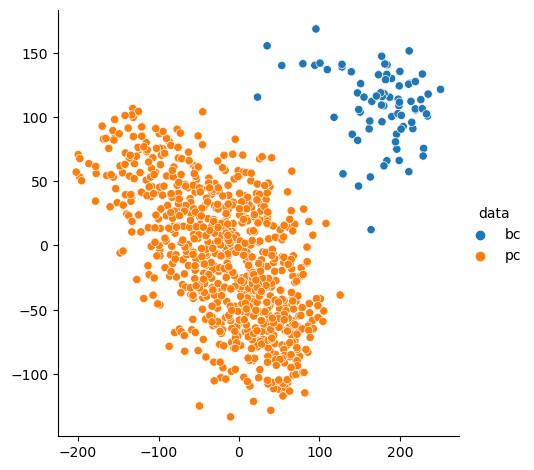

In [127]:
pca_plot = sns.relplot(x=transformed[:,0], y=transformed[:,1], hue  = data.data)

plt.show()

In [192]:
data.index = data.index.str.replace('-', '').str.lower()

overlap = data[data.index.duplicated(keep=False)]

overlap.data.value_counts()

pc    46
bc    44
Name: data, dtype: int64

In [193]:
pca = PCA(n_components=6).fit(overlap.values[:, :-1])
transformed = pca.transform(overlap.values[:,:-1])

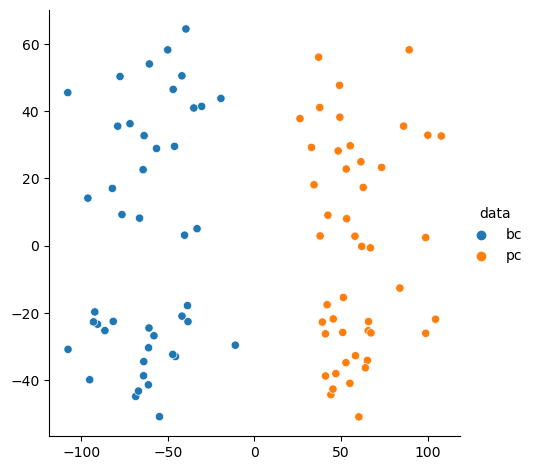

In [195]:
pca_plot = sns.relplot(x=transformed[:,0], y=transformed[:,1], hue  = overlap.data)

plt.show()

In [196]:
pca.explained_variance_ratio_

array([0.31289081, 0.08318471, 0.04597506, 0.03085004, 0.02704558,
       0.02389305])

In [161]:
pca.components_[0].shape

(5331,)

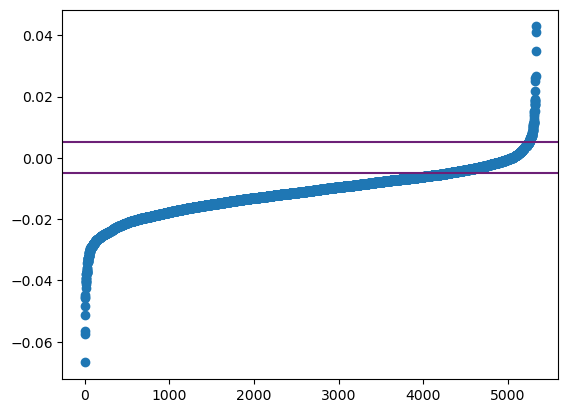

In [322]:
plt.scatter(range(5331), sorted(pca.components_[0]))
plt.axhline(0.005, 0, c="#6D2077")
plt.axhline(-0.005, 0, c="#6D2077")

In [270]:
pca_prots = proteins[(pca.components_[0] < 0.005) & (pca.components_[0] > -0.005)]

In [271]:
pca_prots.shape

(951,)

In [272]:
bc['data'] = 'bc'
pc['data'] = 'pc'

data = pd.concat([bc, pc], join = 'inner').fillna(0)

In [273]:
data.index = data.index.str.replace('-', '').str.lower()

In [274]:
pca_data = data[list(pca_prots) + ['data']]

In [281]:
pca_overlap = pca_data[pca_data.index.duplicated(keep=False)]

pca_overlap.data.value_counts()

pc    46
bc    44
Name: data, dtype: int64

In [282]:
pca_new = PCA(n_components=6).fit(pca_overlap.values[:, :-1])
transformed_new = pca_new.transform(pca_overlap.values[:,:-1])

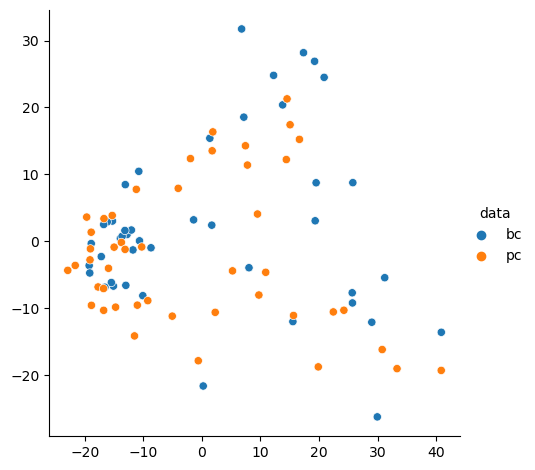

In [287]:
pca_plot = sns.relplot(x=transformed_new[:,0], y=transformed_new[:,1], hue  = pca_overlap.data)

plt.show()

In [284]:
pca_new.explained_variance_ratio_

array([0.15788349, 0.07579112, 0.04876242, 0.04102634, 0.03437371,
       0.03202705])

In [2]:
bc = pd.read_csv('data/bc_protein.csv').set_index('Cell_Line')  
pc = pd.read_csv('data/pc_protein.csv').set_index('Cell_Line')

array([[<Axes: title={'center': 'P00533'}>]], dtype=object)

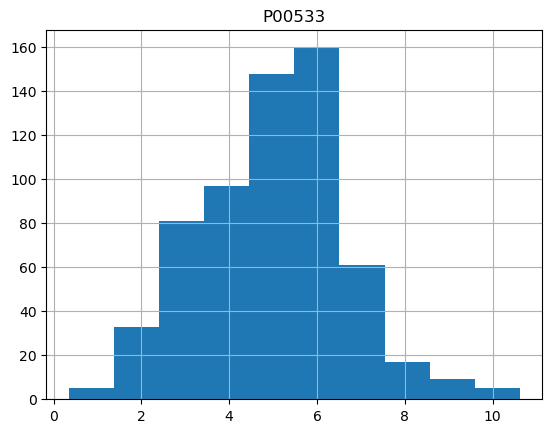

In [4]:
pc[['P00533']].hist()

In [291]:
pc[pca_prots].to_csv('data/pc_pca_protein.csv')
bc[pca_prots].to_csv('data/bc_pca_protein.csv')

### Correlation IC 50 values

In [15]:
bc_response = pd.read_csv('data/bc_drug_response.csv').set_index('cell_line_name')
pc_response = pd.read_csv('data/pc_drug_response.csv').set_index('cell_line_name')

In [16]:
bc_response

,Drug,CHEMBL,IC50,ln_IC50
cell_line_name,,,,
184a1,17-AAG,CHEMBL109480,7.93,2.070653
184b5,17-AAG,CHEMBL109480,7.56,2.022871
600mpe,17-AAG,CHEMBL109480,6.65,1.894617
au565,17-AAG,CHEMBL109480,7.24,1.979621
bt474,17-AAG,CHEMBL109480,5.84,1.764731
...,...,...,...,...
sum225,ZM447439,CHEMBL202721,4.98,1.605430
sum229,ZM447439,CHEMBL202721,5.93,1.780024
sum52,ZM447439,CHEMBL202721,5.46,1.697449


In [4]:
bc_response[bc_response.CHEMBL == 'CHEMBL34259']

,Drug,CHEMBL,IC50,ln_IC50
cell_line_name,,,,
184a1,Methotrexate,CHEMBL34259,7.18,1.971299
184b5,Methotrexate,CHEMBL34259,7.37,1.997418
600mpe,Methotrexate,CHEMBL34259,5.39,1.684545
au565,Methotrexate,CHEMBL34259,5.36,1.678964
bt20,Methotrexate,CHEMBL34259,3.48,1.247032
bt474,Methotrexate,CHEMBL34259,3.48,1.247032
bt483,Methotrexate,CHEMBL34259,3.63,1.289233
bt549,Methotrexate,CHEMBL34259,3.48,1.247032
cama1,Methotrexate,CHEMBL34259,6.97,1.941615


In [5]:
pc_response.index = pc_response.index.str.replace('-', '').str.lower()

In [7]:
response = pd.merge(pc_response, bc_response, on=['CHEMBL', 'cell_line_name'])

<Axes: >

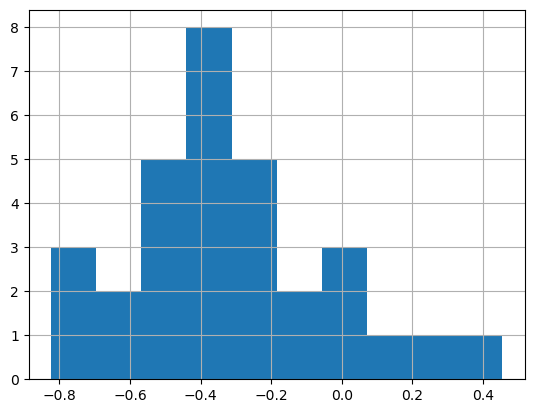

In [8]:
response.groupby('CHEMBL')[['ln_IC50_x', 'ln_IC50_y']].corr().unstack().iloc[:,1].hist()

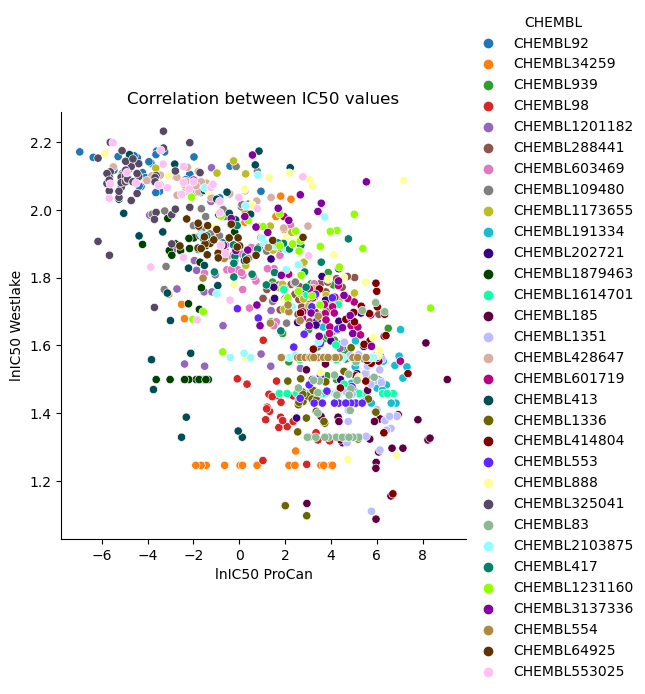

In [30]:
# I looked into the data and it they have the same values, which is not a good sign, could be due to some rounding they did?

s = sns.relplot(response, x='ln_IC50_x', y='ln_IC50_y', hue='CHEMBL', palette=sns.color_palette(cc.glasbey_category10, n_colors=31))
s.set(xlabel='lnIC50 ProCan', ylabel='lnIC50 Westlake', title= f'Correlation between IC50 values')

plt.savefig('analysis/img/IC50_corr.png', bbox_inches='tight')
plt.show()